# Field-Aware Factorization machine predictor

This model uses a Field-Aware Factorization machine in combination with a unsupervised gradient boosted decision tree (30 trees) for feature engineering. The gradient boosted decision tree is regularly trained in a supervised way but instead of using its target predictions the leaf index predictions are used as features for the Field-Aware Factorization machine. This approach was proposed by Xinran He et al. <a href='http://quinonero.net/Publications/predicting-clicks-facebook.pdf' >Practical Lessons from Predicting Clicks on Ads at Facebook</a> and used in the winning solution of the previous Click-Trough prediction competition <a href='https://www.kaggle.com/c/criteo-display-ad-challenge'>Display Advertising Challenge</a>.

Field-Aware Factorization machines proved to be a very strong powerful model in past Click-Trough prediction competitions. They work well when used with categorical features. The used library is <a href='http://xlearn-doc.readthedocs.io'>xLearn</a>.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import gc

import math

def sigmoid(x):
    return 1 / (1 + np.exp(-1*x))

path = '~/.kaggle/competitions/talkingdata-adtracking-fraud-detection/'

## Load and downcast data

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    if df.loc[:, 'device'].dtype != 'int16':
        df.loc[:, 'device'] = df.loc[:, 'device'].astype(np.int16)
    if df.loc[:, 'os'].dtype != 'int16':
        df.loc[:, 'os'] = df.loc[:, 'os'].astype(np.int16)
    if df.loc[:, 'channel'].dtype != 'int16':
        df.loc[:, 'channel'] = df.loc[:, 'channel'].astype(np.int16)
    if 'is_attributed' in df.columns:
        df.loc[:, 'is_attributed'] = df.loc[:, 'is_attributed'].astype(np.int8)
    
    if 'day' in df.columns and df.loc[:, 'day'].dtype != 'int8':
        df.loc[:, 'day'] = df.loc[:, 'day'].astype(np.int8)
    
    return df

In [3]:
def to_drop(df):
    df.drop([c for c in df.columns if 'target_mean' in c or 'freq' in c or c in ['day', 'next_click_shift']],
            axis=1, inplace=True)
    return df

In [4]:
b_include_test = True
n_chunks = 10

with pd.HDFStore('instance-1/home/klauke_peter/store_enc_chunks.h5',  mode='r') as store:
    for n in range(n_chunks):
        df_train_chunk = store.select('df_train_chunk{}'.format(n))
        df_train_chunk = to_drop(df_train_chunk)
        print('Loaded df_train_chunk{}'.format(n))
        
        df_train_chunk = downcast_dtypes(df_train_chunk)
        if n == 0:
            df_train = df_train_chunk
        else:
            df_train = pd.concat([df_train, df_train_chunk])
        del df_train_chunk
        gc.collect()
        
    print('Finished df_train, shape:', df_train.shape)
    
    df_valid =  downcast_dtypes(store.select('df_valid'))
    df_valid = to_drop(df_valid)
    print('Loaded df_valid')
    df_valid = downcast_dtypes(df_valid)
    print('Finished df_valid, shape:', df_valid.shape)
    
    if b_include_test:
        df_test =  downcast_dtypes(store.select('df_test'))
        df_test = to_drop(df_test)
        print('Loaded df_test')
        df_test = downcast_dtypes(df_test)
        print('Finished df_test, shape', df_test.shape)

Loaded df_train_chunk0
Loaded df_train_chunk1
Loaded df_train_chunk2
Loaded df_train_chunk3
Loaded df_train_chunk4
Loaded df_train_chunk5
Loaded df_train_chunk6
Loaded df_train_chunk7
Loaded df_train_chunk8
Loaded df_train_chunk9
Finished df_train, shape: (179903890, 43)
Loaded df_valid
Finished df_valid, shape: (5000000, 43)
Loaded df_test
Finished df_test, shape (18790469, 43)


## Time-based split between training and validation

Create a time-based split between training and validation for proper validation during feature selection and hyperparameter tuning. If there would've been time left in the competition the complete training data (including validation data) should've been used for the final submission.

In [5]:
split_date = pd.Timestamp(year=2017, month=11, day=9, hour=5)

df_train = df_train.loc[df_train.click_time < split_date, :]
gc.collect()

944

In [6]:
df_valid = df_valid.loc[ ((df_valid.minute_of_day > 295) & (df_valid.minute_of_day < 365))
                       | ((df_valid.minute_of_day > 535) & (df_valid.minute_of_day < 665))
                       | ((df_valid.minute_of_day > 770) & (df_valid.minute_of_day < 905))]

gc.collect()

print('train shape: ', df_train.shape)
print('valid shape: ', df_valid.shape)

train shape:  (148239045, 43)
valid shape:  (2327952, 43)


Inspect time-based split. Training data overlaps with validation data because there are multiple days in training data.

/home/klauke_peter/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/home/klauke_peter/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


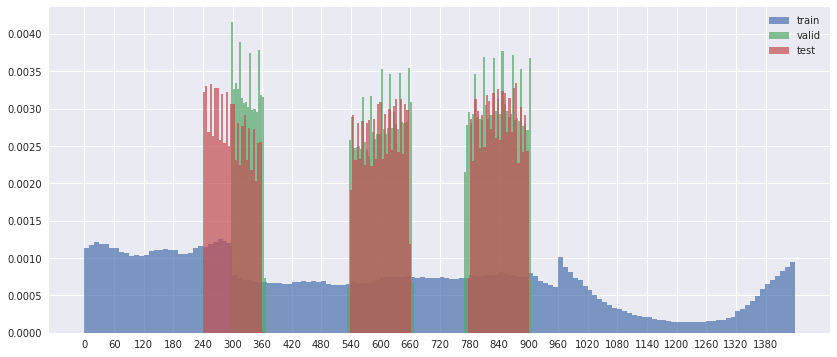

In [7]:
plt.figure(figsize=(14, 6))

plt.hist(df_train.click_time.dt.hour*60 + df_train.click_time.dt.minute, bins=(24*60)//10, normed=True, alpha=0.7, label='train')
plt.hist(df_valid.click_time.dt.hour*60 + df_valid.click_time.dt.minute, bins=(24*60)//10, normed=True, alpha=0.7, label='valid')
if b_include_test:
    plt.hist(df_test.click_time.dt.hour*60 + df_test.click_time.dt.minute, bins=(24*60)//10, normed=True, alpha=0.7, label='test')

plt.legend()
plt.xticks(range(0, 60*24, 60))

plt.show()

# Feature Engineering using Boosted Decision Trees

A gradient boosted decision trees with 30 trees is used for Feature Engineering. Using 30 trees is an arbitrary choice that should've been tuned if there would've been enough time. The features generated by the gradient boosted decision tree are the leaf index predictions.

The features used for the gradient boosted decision tree were carefully selected using Forward Selection.

### Train LightGBM model

In [9]:
features_cat = ['app', 'os', 'channel', 'device', 'hour', 'timeframe_17', 'category_mod_16']
features = features_cat
features += [
                'minute_of_day',
                'next_click',
                'app_nunique_gby_ip_device_os', 'channel_count_gby_ip_app', 'channel_count_gby_ip_app_os',
                'channel_nunique_gby_app', 'channel_nunique_gby_ip', 'day_var_gby_ip_app_channel',
                'device_nunique_gby_ip', 'hour_nunique_gby_ip_day', 'os_count_gby_ip', 'os_nunique_gby_ip_app',
                'ip_os_nextClick',
                'timeframe_11_mean_gby_ip_app_channel'
            ]

In [2]:
from sklearn.metrics import roc_auc_score
import lightgbm

n_trees = 30

lgb_train_set = lightgbm.Dataset(df_train.loc[:, features], label=df_train.loc[:, 'is_attributed'],
                                 feature_name=features,
                                 categorical_feature=[f for f in features if f in features_cat])

lgb_valid_set = lightgbm.Dataset(df_valid.loc[:, features], label=df_valid.loc[:, 'is_attributed'],
                                 feature_name=features,
                                 categorical_feature=[f for f in features if f in features_cat])

                       
params_lgb = {'objective': 'binary', 'metric': 'AUC', 'boosting': 'gbdt', 'learning_rate': 0.2,
              'verbose': 0, 'num_leaves': 128, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'bagging_seed': 1,
              'feature_fraction': 1.0, 'feature_fraction_seed': 1, 'max_bin': 256,
              'min_data_in_leaf': 5000, 'seed': 1, 'lambda_l1': 0, 'lambda_l2': 0,
              'scale_pos_weight': 200, 'two_round': True, 'max_depth': 10,
              'min_sum_hessian_in_leaf': 4000}

lgb = lightgbm.train(params_lgb, 
                     train_set=lgb_train_set,
                     num_boost_round=n_trees,
                     valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'valid'],
                     fobj=None, feval=None, init_model=None,
                     feature_name='auto', categorical_feature='auto', 
                     early_stopping_rounds=None, evals_result=None, verbose_eval=30, learning_rates=None, 
                     keep_training_booster=False, callbacks=None)
    
del lgb_train_set, lgb_valid_set
gc.collect()

[30]	train's auc: 0.985921	valid's auc: 0.974475


In [11]:
import pickle
 
pickle.dump(lgb,  open( 'lgb_le0.2_allchunks_30trees.pkl', 'wb' ) )

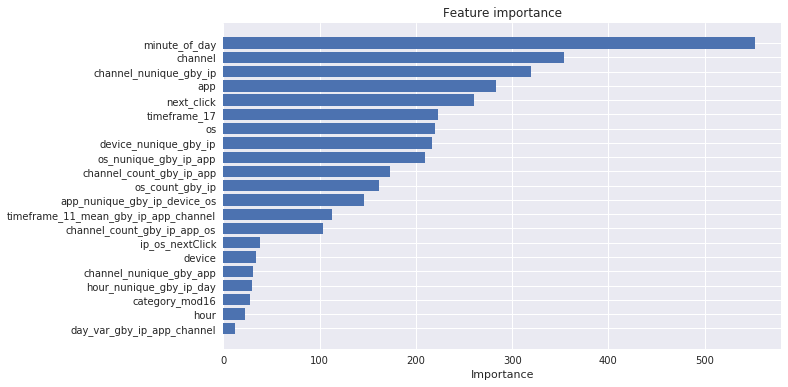

In [11]:
fig = plt.figure(figsize=(10, 6))

feature_importance = lgb.feature_importance()
sorted_idx = np.argsort(feature_importance)

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')
plt.draw()
plt.show()

### Get and save leaf indices prediction

In [ ]:
import pickle

lgb = pickle.load( open('lgb_le0.2_allchunks_30trees.pkl', 'rb'))

In [15]:
n_splits = 10
splitsize = df_train.shape[0] // n_splits

def save_leaves(df, filename):
    cols = ['tree{}_leaf_index'.format(i) for i in range(n_trees)]

    leaf_indices = lgb.predict(df, pred_leaf=True)
    print('\t Finished predicting sample with {} rows'.format(df.shape[0]))
    df_leaf_indices = pd.DataFrame(leaf_indices, columns=cols, dtype=np.int8)
    df_leaf_indices.to_csv('Leaf_predictions/' + filename, index=False)
    
    del df_leaf_indices
    gc.collect()

for split in range(n_splits-1):
    print('Processing split {}'.format(split))
    df_split = df_train.iloc[split*splitsize : (split+1)*splitsize, :]
    save_leaves(df_split.loc[:, features], 'leaves_train_split_{}.csv'.format(split))
    
print('Processing split {}'.format(n_splits-1))
df_split = df_train.iloc[(n_splits-1)*splitsize:, :]
save_leaves(df_split.loc[:, features], 'leaves_train_split_{}.csv'.format(n_splits-1))
print('Finished training sample')

del df_split
gc.collect()

save_leaves(df_valid.loc[:, features], 'leaves_valid.csv')
print('Finished validation sample')

if b_include_test:
    save_leaves(df_test.loc[:, features], 'leaves_test.csv')
    print('Finished test sample')

gc.collect()

Processing split 9
	 Finished predicting sample with 14823909 rows
Finished training sample
	 Finished predicting sample with 2327952 rows
Finished validation sample
	 Finished predicting sample with 18790469 rows
Finished test sample


0

# Regular Feature Engineering

Field-Aware Factorization machines work best with categoric columns therefore numeric columns are binned.

In [12]:
len_train = df_train.shape[0]
len_valid = df_valid.shape[0] 

if b_include_test:
    len_test = df_test.shape[0]
    df_concat = pd.concat([df_train, df_valid, df_test])
    del df_test
else:
    df_concat = pd.concat([df_train, df_valid])

del df_train
del df_valid
gc.collect()

df_concat.shape

(169357466, 42)

In [13]:
for col in ['ip_os_nextClick', 'ip_nextClick', 'ip_app_nextClick',
            'os_count_gby_ip', 'app_nunique_gby_ip_device_os']:
    if col+'_cat' not in df_concat.columns:
        srs_mask = df_concat.loc[:, col].isnull() | np.isinf(df_concat.loc[:, col])
        print('Processing ' + col + ' with ' + str(np.sum(srs_mask)) + ' NaN values.')
        
        if any(srs_mask):
            col_name_na = col + '_cat_na'
            df_concat.loc[srs_mask, col] = -1
            df_concat.loc[srs_mask, col_name_na] = 1
            df_concat.loc[~srs_mask, col_name_na] = 0
            df_concat.loc[:, col_name_na] = df_concat.loc[:, col_name_na].astype(np.int8)

        df_concat.loc[:, col + '_cat'] =  pd.cut(df_concat.loc[:, col], 30, labels=False).astype(np.int8)
    
mod = 8
df_concat.loc[:, 'category_mod{}'.format(mod)] = df_concat.category.apply(lambda x: x % mod)
    
del srs_mask
gc.collect()

Processing ip_os_nextClick with 2912006 NaN values.
Processing ip_nextClick with 263424 NaN values.
Processing ip_app_nextClick with 3523247 NaN values.
Processing os_count_gby_ip with 0 NaN values.
Processing app_nunique_gby_ip_device_os with 0 NaN values.


123

In [14]:
df_train = df_concat.iloc[:len_train, :]
df_valid = df_concat.iloc[len_train:len_train+len_valid, :]

print(df_train.shape)
print(df_valid.shape)

if b_include_test:
    df_test = df_concat.iloc[len_train+len_valid:, :]
    print(df_test.shape)
    
del df_concat
gc.collect()

(148239045, 51)
(2327952, 51)
(18790469, 51)


34

In [15]:
target = 'is_attributed'
features = ['app', 'os', 'channel', 'device', 'timeframe_17', 'category_mod8']
features += [feature for feature in df_train.columns if 'leaf_index' in feature]
features += [feature for feature in df_train.columns if '_cat' in feature]

features = [f for f in features if f != 'target_mean_category_mod16'] # contains _cat, get rid of it

print('{} features'.format(len(features)))

14 features


Field-Aware Factorization Machines may have problems if test data contains categories not appearing in training data. In addition categories with only very few samples may lead to overfitting. Therefore all categories that appear less than 10 times are replaced by the value -1. The same is done for all samples in validation and test data if the respective category of that sample isn't in training data.

In [44]:
for feature in features:
    if 'leaf_index' not in feature:
        print('Processing: ', feature)
        tmp = df_train.loc[:, feature].value_counts() < 10
        tmp = tmp[tmp]
        df_train.loc[df_train.loc[:, feature].apply(lambda x: x in tmp.index), feature] = -1

        set_feature = set(df_train.loc[:, feature])
        df_valid.loc[~df_valid.loc[:, feature].isin(set_feature), feature] = -1

        if b_include_test:
            df_test.loc[~df_test.loc[:, feature].isin(set_feature), feature] = -1

del tmp, set_feature
gc.collect()

Processing:  app
Processing:  os
Processing:  channel
Processing:  device
Processing:  timeframe_17
Processing:  category_mod8
Processing:  ip_os_nextClick_cat_na
Processing:  ip_os_nextClick_cat
Processing:  ip_nextClick_cat_na
Processing:  ip_nextClick_cat
Processing:  ip_app_nextClick_cat_na
Processing:  ip_app_nextClick_cat
Processing:  os_count_gby_ip_cat
Processing:  app_nunique_gby_ip_device_os_cat


389

In [18]:
df_train = df_train.loc[:, [target] + features]
df_valid = df_valid.loc[:, [target] + features]
df_test = df_test.loc[:, [target] + features]
gc.collect()

495

### Load leaf predictions

In [43]:
df_leaves = pd.DataFrame()

n_splits = 10

for i in range(n_splits):
    print('Processing split ', i)
    df_leaves_split = pd.read_csv('Leaf_predictions/leaves_train_split_{}.csv'.format(i), dtype=np.uint8)
    df_leaves = pd.concat([df_leaves, df_leaves_split])
    print('leaves shape: {}'.format(df_leaves.shape))
    #pass

print('Concatenating train')
#df_train = pd.concat([df_train.reset_index(drop=True), df_leaves], axis=1)
for c in df_leaves.columns:
    df_train.loc[:, c] = df_leaves.loc[:, c].values
del df_leaves
gc.collect()
print('train shape: {}'.format(df_train.shape))

df_leaves_valid = pd.read_csv('Leaf_predictions/leaves_valid.csv'.format(i), dtype=np.uint8)
#df_valid = pd.concat([df_valid.reset_index(drop=True), df_leaves_valid], axis=1)
for c in df_leaves_valid.columns:
    df_valid.loc[:, c] = df_leaves_valid.loc[:, c].values
del df_leaves_valid
gc.collect()
print('valid shape: {}'.format(df_valid.shape))

if b_include_test:
    df_leaves_test = pd.read_csv('Leaf_predictions/leaves_test.csv'.format(i), dtype=np.uint8)
    #df_test = pd.concat([df_test.reset_index(drop=True), df_leaves_test], axis=1)
    for c in df_leaves_test.columns:
        df_test.loc[:, c] = df_leaves_test.loc[:, c].values
    del df_leaves_test
    gc.collect()
    print('test shape: {}'.format(df_test.shape))
    
features += [feature for feature in df_train.columns if 'leaf_index' in feature]
df_train.head(n=2)

Concatenating train
train shape: (148239045, 45)
valid shape: (2327952, 45)
test shape: (18790469, 45)


,is_attributed,app,os,channel,device,timeframe_17,category_mod8,ip_os_nextClick_cat_na,ip_os_nextClick_cat,ip_nextClick_cat_na,...,tree20_leaf_index,tree21_leaf_index,tree22_leaf_index,tree23_leaf_index,tree24_leaf_index,tree25_leaf_index,tree26_leaf_index,tree27_leaf_index,tree28_leaf_index,tree29_leaf_index
11,0,3,13,379,1,51,7,0,2,0,...,24,14,21,17,11,28,53,13,38,10
22,0,14,3,478,1,52,2,0,2,0,...,85,22,75,17,37,17,84,14,38,10


### Check category diversity in train, validation and test set

If there are more different categories in one category columns in the test or validation set there is an issue in previous feature engineering.

In [45]:
for col in df_train.loc[:, features].columns:
    if b_include_test:
        print(len(df_train.loc[:, col].unique()), '\t',
              len(df_valid.loc[:, col].unique()), '\t',
              len(df_test.loc[:, col].unique()),  '\t',
              col)
    else:
        print(len(df_train.loc[:, col].unique()), '\t',
              len(df_valid.loc[:, col].unique()), '\t',
              col)

396 	 287 	 342 	 app
281 	 217 	 254 	 os
180 	 171 	 175 	 channel
1033 	 562 	 932 	 device
85 	 23 	 24 	 timeframe_17
8 	 8 	 8 	 category_mod8
2 	 2 	 2 	 ip_os_nextClick_cat_na
30 	 28 	 19 	 ip_os_nextClick_cat
2 	 2 	 2 	 ip_nextClick_cat_na
30 	 26 	 18 	 ip_nextClick_cat
2 	 2 	 2 	 ip_app_nextClick_cat_na
30 	 28 	 19 	 ip_app_nextClick_cat
13 	 13 	 13 	 os_count_gby_ip_cat
29 	 28 	 29 	 app_nunique_gby_ip_device_os_cat
128 	 128 	 127 	 tree0_leaf_index
128 	 128 	 127 	 tree1_leaf_index
128 	 128 	 128 	 tree2_leaf_index
128 	 128 	 128 	 tree3_leaf_index
128 	 128 	 128 	 tree4_leaf_index
128 	 125 	 126 	 tree5_leaf_index
128 	 127 	 127 	 tree6_leaf_index
128 	 128 	 128 	 tree7_leaf_index
128 	 128 	 128 	 tree8_leaf_index
128 	 128 	 128 	 tree9_leaf_index
128 	 128 	 128 	 tree10_leaf_index
128 	 128 	 128 	 tree11_leaf_index
128 	 127 	 128 	 tree12_leaf_index
128 	 126 	 127 	 tree13_leaf_index
128 	 128 	 128 	 tree14_leaf_index
128 	 126 	 126 	 tree15_leaf_in

## Save data sets and convert them into the required format for Field-Aware Factorization machines

Converting is done using the script in repository <a href='https://github.com/pklauke/LibFFMGenerator'>LibFFMGenerator</a>.

In [47]:
df_train.loc[:, [target] + features].to_csv('LibFFM/trainffm.csv', index=False, header=False)
print('train finished')
df_valid.loc[:, [target] + features].to_csv('LibFFM/validffm.csv', index=False, header=False)
print('valid finished')

if b_include_test:
    df_test.loc[:, [target] + features].to_csv('LibFFM/testffm.csv', index=False, header=False)
    print('test finished')

train finished
valid finished
test finished


In [48]:
import os

if b_include_test:
    os.system('LibFFMGenerator/LibffmGenerator.out LibFFM/trainffm.csv --valid LibFFM/validffm.csv --test LibFFM/testffm.csv --n_train {} --n_valid {} --n_test {}'.format(df_train.shape[0], df_valid.shape[0], df_test.shape[0]))
else:
    os.system('LibFFMGenerator/LibffmGenerator.out LibFFM/trainffm.csv --valid LibFFM/validffm.csv --n_train {} --n_valid {}'.format(df_train.shape[0], df_valid.shape[0]))

# Modelling 

In [25]:
import xlearn as xl


# Training task
ffm_model = xl.create_ffm()  # Use field-aware factorization machine
ffm_model.setTrain("./LibFFM/trainffm_ffmGen.txt")   # Training data
ffm_model.setValidate("./LibFFM/validffm_ffmGen.txt")  # Validation data

# On-disk training
#ffm_model.setOnDisk()

param = {#'block_size': 100000,
         'task':'binary', # ‘binary’ for classification, ‘reg’ for Regression
         'k':8,           # Size of latent factor
         'lr':0.05, #0.05       # Learning rate for GD
         'lambda':0.00001, # L2 Regularization Parameter
         'metric':'auc',  # Metric for monitoring validation set performance
         'epoch':10,      # Maximum number of Epochs
         'opt':'adagrad'#, #'adagrad' 'sgd' 'ftrl'
        }

# Train model
ffm_model.disableEarlyStop()
#ffm_model.disableLockFree()
ffm_model.fit(param, "./LibFFM/model_2.out")

In [48]:
import xlearn as xl

# Training task
ffm_model = xl.create_ffm()

ffm_model.setTest("./LibFFM/validffm_ffmGen.txt")
ffm_model.setSigmoid()
ffm_model.predict("./LibFFM/model_2.out", "./LibFFM/preds_valid_ffm_2.txt")

# Create submission file 

In [51]:
import xlearn as xl

# Training task
ffm_model = xl.create_ffm()

ffm_model.setTest("./LibFFM/testffm_ffmGen.txt")
ffm_model.setSigmoid()
ffm_model.predict("./LibFFM/model_2.out", "./LibFFM/preds_test_ffm_2.txt")

In [33]:
df_submission = pd.read_csv('instance-1/home/klauke_peter/.kaggle/competitions/talkingdata-adtracking-fraud-detection/sample_submission.csv.zip')
#df_submission = downcast_dtypes(df_submission)
df_submission.head(n=2)

,click_id,is_attributed
0,0,0
1,1,0


In [34]:
preds_test = pd.read_csv('LibFFM/preds_test_ffm_2.txt', header=None).values

In [47]:
preds_test[np.isnan(preds_test)] = np.mean(preds_test[~np.isnan(preds_test)])

In [50]:
df_submission.loc[:, 'is_attributed'] = preds_test
df_submission.to_csv('submission.csv.gz', index = False, compression = 'gzip', float_format='%.9f')

df_submission.head()

,click_id,is_attributed
0,0,0.000273
1,1,0.000909
2,2,0.000146
3,3,0.000266
4,4,0.000172


In [51]:
import os

subname = 'gcp {}chunks le{} ffm only 44 features'.format(n_chunks, 0.02)
os.system('kaggle competitions submit -c talkingdata-adtracking-fraud-detection -f submission.csv.gz -m "{}"'.format(subname))

-1

### Check validation / test differences

In [48]:
print('predictions valid mean: ' + str(np.mean(preds_valid)))
print('predictions test mean: ' + str(np.mean(preds_test)))

predictions valid mean: 0.0027907130050056944
predictions test mean: 0.0033897322145735307


/home/klauke_peter/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


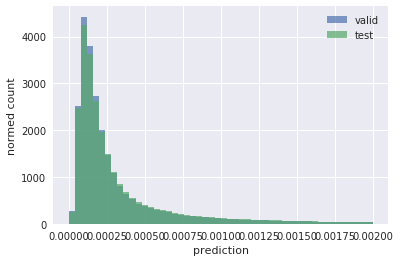

In [49]:
plt.hist(preds_valid, normed=True, label='valid', alpha=0.7, bins=50, range=(0, 0.002))
plt.hist(preds_test, normed=True, label='test', alpha=0.7, bins=50, range=(0, 0.002))

plt.legend()
plt.xlabel('prediction')
plt.ylabel('normed count')

plt.show()

In [ ]:
df_test.loc[:, 'prediction'] = preds_test
df_test.loc[:, 'prediction'] = df_test.loc[:, 'prediction'].astype(np.float32)
df_test.loc[:, ['prediction']].to_csv('predictions_test_new.csv')

#preds_valid = lgb.predict(df_valid.loc[:, lgb_features])
print('Valid AUC: {:0.5f}'.format(roc_auc_score(df_valid.loc[:, 'is_attributed'], preds_valid)))
df_valid.loc[:, 'prediction'] = preds_valid
df_valid.loc[:, 'prediction'] = df_valid.loc[:, 'prediction'].astype(np.float32)
df_valid.loc[:, ['prediction']].to_csv('predictions_valid_new.csv')


cols_to_read = ['is_attributed']
df_train = pd.read_csv(path+'train.csv.zip', usecols=cols_to_read)

#preds_train = lgb.predict(lightgbm.Dataset('lgb_train_data.bin'))
print('Train AUC: {:0.5f}'.format(roc_auc_score(df_train.loc[:, 'is_attributed'], preds_train)))
df_train.loc[:, 'prediction'] = preds_train
df_train.loc[:, 'prediction'] = df_train.loc[:, 'prediction'].astype(np.float32)
df_train.loc[:, ['prediction']].to_csv('predictions_train_new.csv')